# <div align="center">Linear approximation of $\sqrt{1+x}$ where $x \in [0,1]$</div>
---------------------------------------------------------------------

In [1]:
import pandas as pd

import numpy as np
from numpy.linalg import inv

from matplotlib import pyplot as plt
plt.style.use(['ggplot'])
%matplotlib inline
fig = plt.figure(figsize = (16,8))

from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import tensorflow as tf
print('tensorflow versio: ', tf.__version__)

import warnings
warnings.filterwarnings('ignore')

tensorflow versio:  1.14.0


<Figure size 1152x576 with 0 Axes>

In [2]:
np.random.seed(22)
tf.set_random_seed(22)

In [3]:
# Number of data points 
n = 10000

In [4]:
X = np.random.random(n).reshape((n, 1))
y = np.sqrt(1+X)

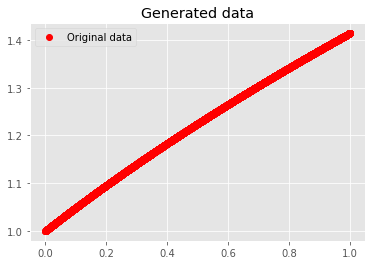

In [5]:
plt.plot(X, y, 'ro', label ='Original data')
plt.title('Generated data')
plt.legend()
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

# 1. With closed-form:

For linear regression on a model of the form $y=X \beta$, where $X$ is a matrix with ***full column rank***, the least squares solution,

$\hat{\beta}=argmin||X \beta - y||_{2}$

is given by

$\hat{\beta}=(X^{T}X)^{-1}X^{T}y$

Here requires the inversion of $X^{T}X$. If this matrix is not of full rank (i.e. there are linearly dependent columns) or if it is poorly conditioned (i.e. eigen values which are very close to zero) then the inversion can either be impossible, or numerically unstable.

A solution is to add a small element to the diagonal such that the eigen-values (and the matrix) are better conditioned

$\hat{\beta} = (X^{T}X+ \lambda^{2} I_{n})^{-1}X^{T}y$

This is actually the solution to the following quadratic cost function:

$J(\beta)=(y - X \beta )^{T} (y - X \beta) + \lambda^{2} \beta ^{T} \beta$

This is proven as follows:

$J(\beta)=(y - X \beta )^{T} (y - X \beta) + \lambda^{2} \beta ^{T} \beta = 
(y^{T} - \beta^{T} X^{T} ) (y - X \beta) + \lambda^{2} \beta ^{T} \beta = 
y^{T}y - y^{T}X \beta - \beta^{T} X^{T}y + \beta^{T} X^{T}X \beta + \lambda^{2} \beta ^{T} \beta = 
y^{T}y - 2\beta^{T} X^{T}y + \beta^{T} X^{T}X \beta + \lambda^{2} \beta ^{T} \beta$

Then Calculate gradient by $\beta$ and we will obtain above mentioned equation.

In [7]:
# create vector of ones
int = np.ones(shape=y_train.shape[0])[..., None]

#and add to feature matrix
X_train_with_ones = np.concatenate((int, X_train), 1)

In [8]:
# # calculate coefficients using closed-form solution
# coeffs = inv(X_train_with_ones.transpose().dot(X_train_with_ones)).dot(X_train_with_ones.transpose()).dot(y_train)

In [9]:
def closed_form_reg_solution(X, y, lamda = 0.1): 
    '''
    Closed form solution for ridge regression
    
    Parameters:
        X (list or nd.array) - actual inputs
        y (list or nd.array) - actual labels
        lambda(float)
        
    Returns:
        list (coefficients)
    '''
    m,n = X.shape
    I = np.eye((n))
    return (inv(X.transpose().dot(X) + lamda * I)).dot(X.transpose()).dot(y)[:,0]

In [10]:
def mse(actual, predicted):
    """
    Calculate mean squared error
    
    Parameters:
        actual (nd.array) - actual values
        predicted (nd.array) - predicted values
    
    Return:
        float(mse)
    """
    return (np.square(actual - predicted)).mean()

In [11]:
lambdas = [0.01, 0.1, 1, 10]
mse_s = []
for i in range(len(lambdas)):
    coeffs = closed_form_reg_solution(X_train_with_ones, y_train, lamda=lambdas[i])
    prediction = coeffs[0] * X_val + coeffs[1]
    mse_s.append(mse(y_val,prediction ))

In [12]:
best_lambda_index = np.argmin(mse_s)

In [13]:
best_lambda = lambdas[best_lambda_index]

In [14]:
coeffs = closed_form_reg_solution(X_train_with_ones, y_train, lamda=best_lambda)

In [15]:
intercept_closed_form = np.round(coeffs[0], 3)
slope_closed_form = np.round(coeffs[1], 3)
print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_closed_form, slope_closed_form))
print('Approximated function: ', intercept_closed_form, '+', slope_closed_form, '* X' )

Intercept:       1.010,
Slope:           0.414
Approximated function:  1.01 + 0.414 * X


MSE in Test dataset:  3.213040634227542e-05


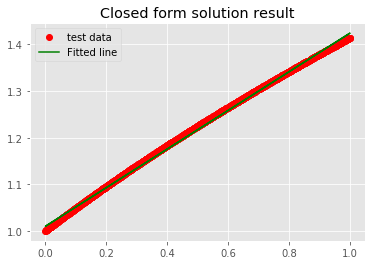

In [16]:
prediction_closed_form = slope_closed_form * X_test + intercept_closed_form

print('MSE in Test dataset: ', mse(y_test, prediction_closed_form))

plt.plot(X_test, y_test, 'ro', label ='test data')
plt.plot(X_test, prediction_closed_form, label ='Fitted line', color='green')
plt.title('Closed form solution result')
plt.legend()
plt.show()

# 2. With sklearn

In [17]:
lambdas = [0.01, 0.1, 1, 10]
mse_s = []

for i in range(len(lambdas)):
    
    regressor = Ridge(alpha=i, random_state=42)
    regressor.fit(X_train, y_train)
    prediction = regressor.predict(X_val)
    mse_s.append(mse(y_val, prediction ))

In [18]:
best_lambda_index = np.argmin(mse_s)

In [19]:
best_lambda = lambdas[best_lambda_index]

In [20]:
regressor = Ridge(alpha=best_lambda, random_state=42)
regressor.fit(X_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)

In [21]:
intercept_ridge = np.round(regressor.intercept_[0], 3)
slope_ridge = np.round(regressor.coef_[0, 0], 3)
print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_ridge, slope_ridge))
print('Approximated function: ', intercept_ridge, '+', slope_ridge, '* X' )

Intercept:       1.013,
Slope:           0.412
Approximated function:  1.013 + 0.412 * X


MSE in Test dataset:  2.807983644111036e-05


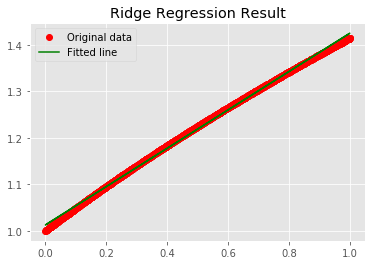

In [22]:
prediction_ridge = regressor.predict(X_test)

print('MSE in Test dataset: ', mse(y_test, prediction_ridge))

plt.plot(X_test, y_test, 'ro', label ='Original data')
plt.plot(X_test, prediction_ridge, label ='Fitted line', color='green')
plt.title('Ridge Regression Result')
plt.legend()
plt.show()

In [23]:
regressor_lr = LR()
regressor_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [24]:
intercept_lr = np.round(regressor_lr.intercept_[0], 3)
slope_lr = np.round(regressor_lr.coef_[0, 0], 2)
print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_lr, slope_lr))
print('Approximated function: ', intercept_lr, '+', slope_lr, '* X' )

Intercept:       1.013,
Slope:           0.410
Approximated function:  1.013 + 0.41 * X


MSE in Test dataset:  2.808075194613095e-05


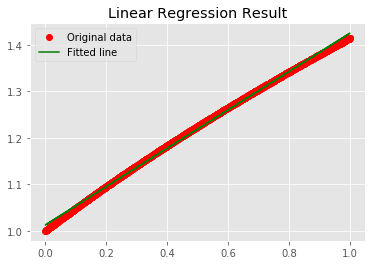

In [25]:
prediction_lr = regressor_lr.predict(X_test)

print('MSE in Test dataset: ', mse(y_test, prediction_lr))

plt.plot(X_test, y_test, 'ro', label ='Original data')
plt.plot(X_test, prediction_lr, label ='Fitted line', color='green')
plt.title('Linear Regression Result')
plt.legend()
plt.show()

# 3. With Implemented gradient descent

<b>Gradient</b>

\begin{equation}
\frac{\partial J(\theta)}{\partial \theta_j} = 1/m\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_j^{(i)}
\end{equation}

<b>Gradients</b>
\begin{equation}
\theta_0: = \theta_{0} -\alpha . (1/m .\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_0^{(i)})
\end{equation}
\begin{equation}
\theta_1: = \theta_{1} -\alpha . (1/m .\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_1^{(i)})
\end{equation}
\begin{equation}
\theta_2: = \theta_{2} -\alpha . (1/m .\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_2^{(i)})
\end{equation}

\begin{equation}
\theta_j: = \theta_{j} -\alpha . (1/m .\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_0^{(i)})
\end{equation}

In [26]:
def gradient_descent(X, y, theta, learning_rate=0.01, iterations=100):
    '''
    Parameters:
        X     = Matrix of X with added bias units
        y     = Vector of Y
        theta = Vector of thetas
        learning_rate 
        iterations = no of iterations
    
    Returns:
        np.array - (Returns the final theta vector)
    '''
    m = len(y)
    for it in range(iterations):
        
        prediction = np.dot(X,theta)
        
        theta = theta -(1/m)*learning_rate*( X.T.dot(prediction - y))
    return theta

In [27]:
lr =0.01
n_iter = 100000

theta = np.random.randn(2,1)

theta = gradient_descent(X_train_with_ones, y_train, theta, lr, n_iter)

intercept_gd = np.round(theta[0,0], 3)
slope_gd = np.round(theta[1,0], 3)

print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_gd, slope_gd))
print('Approximated function: ', intercept_gd, '+', slope_gd, '* X' )

Intercept:       1.013,
Slope:           0.412
Approximated function:  1.013 + 0.412 * X


MSE in Test dataset:  2.8101919897575106e-05


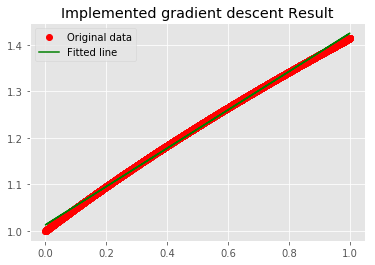

In [28]:
prediction_gd = slope_gd * X_test + intercept_gd

print('MSE in Test dataset: ', mse(y_test, prediction_gd))

plt.plot(X_train, y_train, 'ro', label ='Original data')
plt.plot(X_test, prediction_gd, label ='Fitted line', color='green')
plt.title('Implemented gradient descent Result')
plt.legend()
plt.show()

In [29]:
def gradient_descent_with_regularization(X, y, theta, learning_rate=0.01, iterations=100, lamda = 0.1):
    '''
    Gradient descent for ridge regression
    
    Parameters:
        X     = Matrix of X with added bias units
        y     = Vector of Y
        theta = Vector of thetas
        learning_rate 
        iterations = no of iterations
        lamda = regularization parameter
    
    Returns:
        np.array - (Returns the final theta vector)
    
    '''
    m = len(y)
    for it in range(iterations):
        
        prediction = np.dot(X,theta)

        theta = theta -(1/m)*learning_rate*( X.T.dot(prediction - y) + lamda * theta)
    return theta

In [30]:
lr =0.01
n_iter = 100000

lambdas = [0.01, 0.1, 1, 10]
mse_s = []
for i in range(len(lambdas)):
    theta = np.random.randn(2,1)

    theta = gradient_descent_with_regularization(X_train_with_ones, y_train, theta, lr, n_iter, i)
    
    prediction = theta[1,0] * X_val + theta[0,0]
    
    mse_s.append(mse(y_val, prediction ))

In [31]:
best_lambda_index = np.argmin(mse_s)

In [32]:
best_lambda = lambdas[best_lambda_index]

In [33]:
lr =0.01
n_iter = 100000

theta = np.random.randn(2,1)

theta = gradient_descent_with_regularization(X_train_with_ones, y_train, theta, lr, n_iter, best_lambda)

intercept_rgd = np.round(theta[0,0], 3)
slope_rgd = np.round(theta[1,0], 3)

print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_rgd, slope_rgd))
print('Approximated function: ', intercept_rgd, '+', slope_rgd, '* X' )

Intercept:       1.013,
Slope:           0.412
Approximated function:  1.013 + 0.412 * X


MSE in Test dataset:  2.8101919897575106e-05


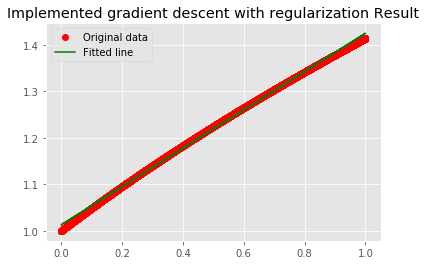

In [34]:
prediction_rgd = slope_rgd * X_test + intercept_rgd

print('MSE in Test dataset: ', mse(y_test, prediction_rgd))

plt.plot(X_train, y_train, 'ro', label ='Original data')
plt.plot(X_test, prediction_rgd, label ='Fitted line', color='green')
plt.title('Implemented gradient descent with regularization Result')
plt.legend()
plt.show()

In [35]:
def stocashtic_gradient_descent(X, y, theta, learning_rate=0.01, iterations=100):
    '''
    Stochastic gradient descent
    
    Parameters:
        X     = Matrix of X with added bias units
        y     = Vector of Y
        theta = Vector of thetas
        learning_rate 
        iterations = no of iterations
    
    Returns:
        np.array - (Returns the final theta vector)
    
    '''
    m = len(y)
    
    for it in range(iterations):
        for i in range(m):
            rand_ind = np.random.randint(0,m)
            X_i = X[rand_ind,:].reshape(1,X.shape[1])
            y_i = y[rand_ind].reshape(1,1)
            prediction = np.dot(X_i,theta)

            theta = theta -(1/m)*learning_rate*( X_i.T.dot((prediction - y_i)))
    return theta

In [36]:
## It takes a long time

# lr =0.01
# n_iter = 10000

# theta = np.random.randn(2,1)

# theta = stocashtic_gradient_descent(X_train_with_ones, y_train, theta, lr, n_iter)

# intercept_sgd = np.round(theta[0,0], 3)
# slope_sgd = np.round(theta[1,0], 3)

# print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_sgd, slope_sgd))
# print('Approximated function: ', intercept_sgd, '+', slope_sgd, '* X' )

In [37]:
# prediction_sgd = slope_sgd * X_test + intercept_sgd

# print('MSE in Test dataset: ', mse(y_test, prediction_sgd))

# plt.plot(X_train, y_train, 'ro', label ='Original data')
# plt.plot(X_test, prediction_sgd, label ='Fitted line', color='green')
# plt.title('Implemented stochastic gradient descent Result')
# plt.legend()
# plt.show()

In [38]:
import math
def minibatch_gradient_descent(X, y, theta, learning_rate=0.01, iterations=100, batch_size = 20):
    '''
    Minibatch gradient descent
    
    Parameters:
        X    = Matrix of X without added bias units
        y    = Vector of Y
        theta=Vector of thetas np.random.randn(j,1)
        learning_rate 
        iterations = no of iterations
        batch_size
    
    Returns:
        np.array - (Returns the final theta vector)
    
    '''
    m = len(y)
    n_batches = math.floor(m/batch_size)
#     n_batches = int(m/batch_size)
    
    for it in range(iterations):
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        for i in range(0,m,batch_size):
            X_i = X[i:i+batch_size]
            y_i = y[i:i+batch_size]
            
            X_i = np.c_[np.ones(len(X_i)),X_i]
           
            prediction = np.dot(X_i,theta)

            theta = theta -(1/m)*learning_rate*( X_i.T.dot((prediction - y_i)))
        
    return theta

In [39]:
lr =0.01
n_iter = 10000
batch_size = 20

theta = np.random.randn(2,1)

theta = minibatch_gradient_descent(X_train, y_train, theta, lr, n_iter, batch_size)

intercept_mgd = np.round(theta[0,0], 3)
slope_mgd = np.round(theta[1,0], 3)

print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_mgd, slope_mgd))
print('Approximated function: ', intercept_mgd, '+', slope_mgd, '* X' )

Intercept:       1.012,
Slope:           0.413
Approximated function:  1.012 + 0.413 * X


MSE in Test dataset:  2.8419154530929472e-05


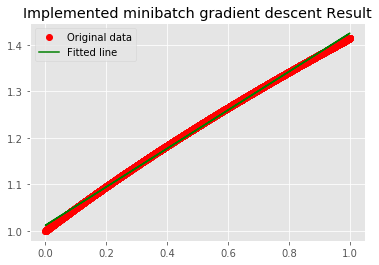

In [40]:
prediction_mgd = slope_mgd * X_test + intercept_mgd

print('MSE in Test dataset: ', mse(y_test, prediction_mgd))

plt.plot(X_train, y_train, 'ro', label ='Original data')
plt.plot(X_test, prediction_mgd, label ='Fitted line', color='green')
plt.title('Implemented minibatch gradient descent Result')
plt.legend()
plt.show()

# 4. With Tensorflow

In [41]:
X = tf.placeholder("float")
Y = tf.placeholder("float")

In [42]:
W = tf.Variable(np.random.randn(), name = "W")
b = tf.Variable(np.random.randn(), name = "b")

In [43]:
learning_rate = 0.01
training_epochs = 100

In [44]:
y_pred = tf.add(tf.multiply(X, W), b)

# Mean Squared Error Cost Function
cost = tf.reduce_sum(tf.pow(y_pred-Y, 2)) / (2 * n)

# Gradient Descent Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

W0924 23:14:20.509317 10128 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [46]:
with tf.Session() as sess: 
    
    sess.run(init)
    
    for epoch in range(training_epochs):
        for (_x, _y) in zip(X_train, y_train):
            sess.run(optimizer, feed_dict = {X : _x, Y : _y})
            
        if (epoch + 1) % 50 == 0:
            c = sess.run(cost, feed_dict = {X : X_train, Y : y_train})
            print("Epoch", (epoch + 1), ": cost =", c, "W =", sess.run(W), "b =", sess.run(b))

    weight = sess.run(W)
    bias = sess.run(b)

Epoch 50 : cost = 0.3669787 W = 0.3993049 b = -0.051624123
Epoch 100 : cost = 0.16549797 W = 0.5393183 b = 0.23081736


In [47]:
intercept_tf = bias
slope_tf = weight

print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_tf, slope_tf))
print('Approximated function: ', intercept_tf, '+', slope_tf, '* X' )

Intercept:       0.231,
Slope:           0.539
Approximated function:  0.23081736 + 0.5393183 * X


MSE in Test dataset:  0.5177013350286312


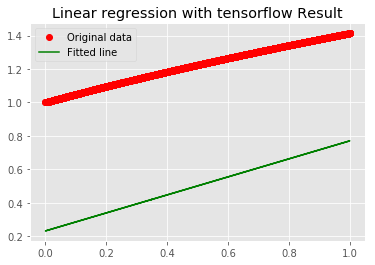

In [48]:
prediction_tf = slope_tf * X_test + intercept_tf

print('MSE in Test dataset: ', mse(y_test, prediction_tf))

plt.plot(X_train, y_train, 'ro', label ='Original data')
plt.plot(X_test, prediction_tf, label ='Fitted line', color='green')
plt.title('Linear regression with tensorflow Result')
plt.legend()
plt.show()

##  Compare all solutions with the first degree Taylor approximation of the function $\sqrt{x+1}$

First degree Taylor approximation of the function $\sqrt{x+1}$ around x=0 is $1 + 1/2 x$

In [49]:
print('coefficients with closed form')
print('-'*50)
print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_closed_form, slope_closed_form))
print('\n')

print('coefficients with ridge regression')
print('-'*50)
print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_ridge, slope_ridge))
print('\n')

print('coefficients with lr')
print('-'*50)
print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_lr, slope_lr))
print('\n')

print('coefficients with gradient descent')
print('-'*50)
print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_gd, slope_gd))
print('\n')

print('coefficients with regularized gradient descent')
print('-'*50)
print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_rgd, slope_rgd))
print('\n')

print('coefficients with tensorflow')
print('-'*50)
print('Intercept:       {:0.3f},\nSlope:           {:0.3f}'.format(intercept_tf, slope_tf))
print('\n')

coefficients with closed form
--------------------------------------------------
Intercept:       1.010,
Slope:           0.414


coefficients with ridge regression
--------------------------------------------------
Intercept:       1.013,
Slope:           0.412


coefficients with lr
--------------------------------------------------
Intercept:       1.013,
Slope:           0.410


coefficients with gradient descent
--------------------------------------------------
Intercept:       1.013,
Slope:           0.412


coefficients with regularized gradient descent
--------------------------------------------------
Intercept:       1.013,
Slope:           0.412


coefficients with tensorflow
--------------------------------------------------
Intercept:       0.231,
Slope:           0.539




from the above printed coefficients values we can say, that closed form (with regularization) gives the best (close to the actual coefficients in taylor series) result among others.

## Can you implement the polynomial regression using linear regression?

In [50]:
poly = PolynomialFeatures(degree = 4)
X_train_poly = poly.fit_transform(X_train)

In [51]:
X_train_poly

array([[1.        , 0.52453875, 0.27514091, 0.14432207, 0.07570252],
       [1.        , 0.54196234, 0.29372318, 0.1591869 , 0.08627331],
       [1.        , 0.93854611, 0.8808688 , 0.82673598, 0.77592984],
       ...,
       [1.        , 0.70716309, 0.50007963, 0.35363786, 0.25007964],
       [1.        , 0.30338642, 0.09204332, 0.02792469, 0.00847197],
       [1.        , 0.20287155, 0.04115686, 0.00834956, 0.00169389]])

In [52]:
regressor_lr_poly = LR()
regressor_lr_poly.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [53]:
intercept_lr_poly = np.round(regressor_lr_poly.intercept_[0], 3)
slope_1_lr_poly = np.round(regressor_lr_poly.coef_[0,1], 3)
slope_2_lr_poly = np.round(regressor_lr_poly.coef_[0,2], 3)
slope_3_lr_poly = np.round(regressor_lr_poly.coef_[0,3], 3)
slope_4_lr_poly = np.round(regressor_lr_poly.coef_[0,4], 3)
print('Intercept:       {:0.3f},\nSlope 1:         {:0.3f},\nSlope 2:         {:0.3f},\nSlope 3:         {:0.3f},\nSlope 4:         {:0.3f}'.format(intercept_lr_poly, slope_1_lr_poly, slope_2_lr_poly, slope_3_lr_poly, slope_4_lr_poly))
print('Approximated function: ', intercept_lr_poly, '+', slope_1_lr_poly, '* X', '+(', slope_2_lr_poly, ')* X^2', '+(', slope_3_lr_poly, ')* X^3', '+(', slope_4_lr_poly, ')* X^4' )

Intercept:       1.000,
Slope 1:         0.499,
Slope 2:         -0.119,
Slope 3:         0.044,
Slope 4:         -0.010
Approximated function:  1.0 + 0.499 * X +( -0.119 )* X^2 +( 0.044 )* X^3 +( -0.01 )* X^4


MSE in Test dataset:  3.540155716376639e-11


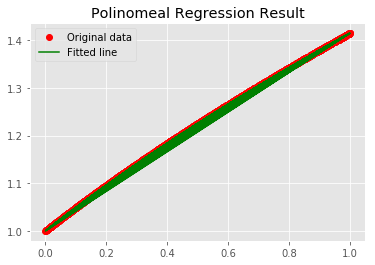

In [54]:
X_test_poly = poly.fit_transform(X_test)
prediction_poly = regressor_lr_poly.predict(X_test_poly)

print('MSE in Test dataset: ', mse(y_test, prediction_poly))

plt.plot(X_test, y_test, 'ro', label ='Original data')
plt.plot(X_test, prediction_poly, label ='Fitted line', color='green')
plt.title('Polinomeal Regression Result')
plt.legend()
plt.show()

# All approximations 

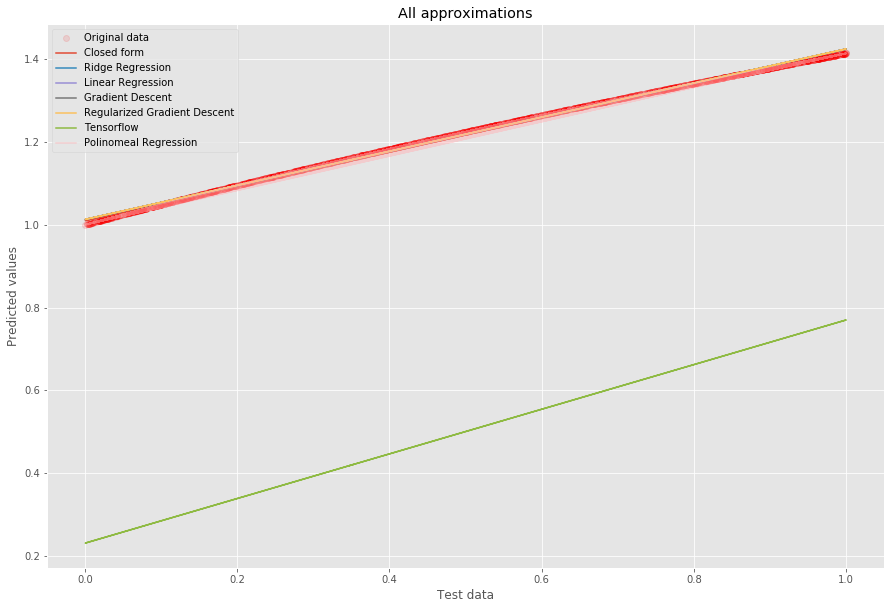

In [55]:
plt.figure(figsize = (15, 10))

plt.plot(X_test, y_test, 'ro', label ='Original data', alpha=0.1)

plt.plot(X_test, prediction_closed_form, label = 'Closed form')
plt.plot(X_test, prediction_ridge, label = 'Ridge Regression')
plt.plot(X_test, prediction_lr, label = 'Linear Regression')
plt.plot(X_test, prediction_gd, label = 'Gradient Descent')
plt.plot(X_test, prediction_rgd, label = 'Regularized Gradient Descent')
plt.plot(X_test, prediction_tf, label = 'Tensorflow')
plt.plot(X_test, prediction_poly, label = 'Polinomeal Regression', alpha = 0.5)

plt.title('All approximations')
plt.xlabel('Test data')
plt.ylabel('Predicted values')
plt.legend()
plt.show()